In [42]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import beta

1. generate 10 samples from bernoulli distribution with theta = 0.3

In [43]:
theta = 0.3
N = 11
np.random.seed(12345)
samples = np.random.binomial(1, theta, N)
y = samples
print(samples)

[1 0 0 0 0 0 1 0 1 0 1]


In [44]:
# maximum likelihood estimation
theta_hat = np.mean(samples)
print(theta_hat)

0.36363636363636365


0.38461538461538464 0.36363636363636365


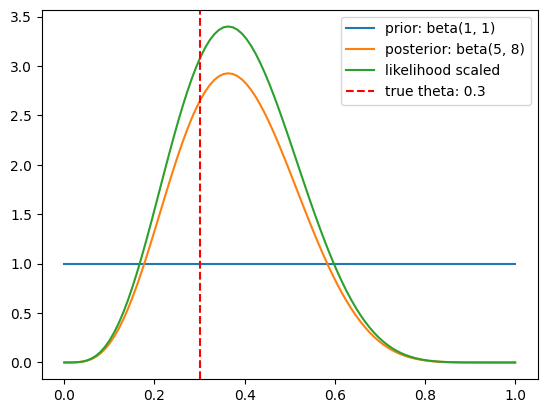

In [45]:
alpha_prior = 1
beta_prior = 1
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N - np.sum(y)
theta_post = alpha_post / (alpha_post + beta_post)  # posterior mean
theta_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # posterior mode
print(theta_post, theta_map)

th = np.linspace(0, 1, 100) # theta values
likelihood = th**np.sum(y) * (1-th)**(N-np.sum(y)) # likelihood function
likelihood *= 3.4/np.max(likelihood)  # scale up for visualization

pdf_beta_prior = beta.pdf(th, alpha_prior, beta_prior)
pdf_beta_post = beta.pdf(th, alpha_post, beta_post)
plt.plot(th, pdf_beta_prior, label=f'prior: beta({alpha_prior}, {beta_prior})')
plt.plot(th, pdf_beta_post, label=f'posterior: beta({alpha_post}, {beta_post})')
plt.plot(th, likelihood, label='likelihood scaled')
plt.axvline(theta, color='red', linestyle='dashed', label=f'true theta: {theta}')
plt.legend();

0.4 0.38461538461538464


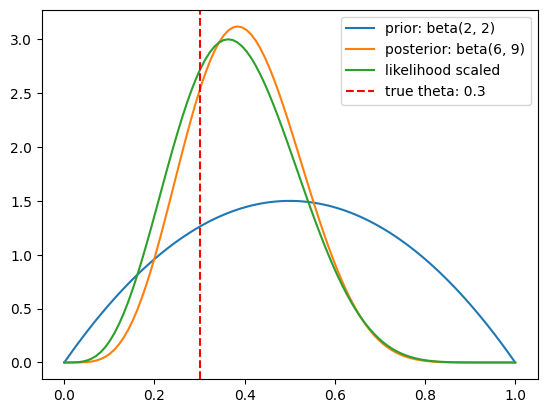

In [46]:
alpha_prior = 2
beta_prior = 2
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N - np.sum(y)
theta_post = alpha_post / (alpha_post + beta_post)  # posterior mean
theta_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # posterior mode
print(theta_post, theta_map)



th = np.linspace(0, 1, 100)
likelihood = th**np.sum(y) * (1-th)**(N-np.sum(y))
likelihood *= 3/np.max(likelihood)  # scale up for visualization

pdf_beta_prior = beta.pdf(th, alpha_prior, beta_prior)
pdf_beta_post = beta.pdf(th, alpha_post, beta_post)
plt.plot(th, pdf_beta_prior, label=f'prior: beta({alpha_prior}, {beta_prior})')
plt.plot(th, pdf_beta_post, label=f'posterior: beta({alpha_post}, {beta_post})')
plt.plot(th, likelihood, label='likelihood scaled')
plt.axvline(theta, color='red', linestyle='dashed', label=f'true theta: {theta}')
plt.legend();

0.42857142857142855 0.42105263157894735


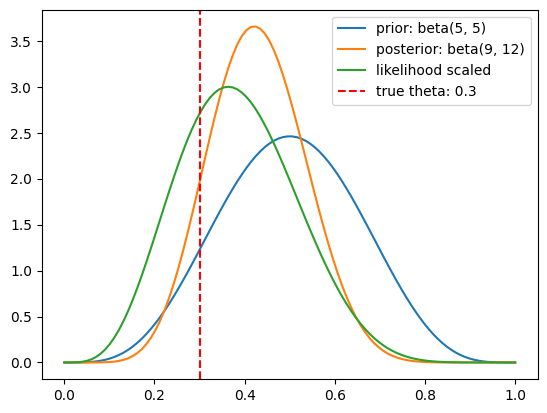

In [47]:
alpha_prior = 5
beta_prior = 5
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N - np.sum(y)
theta_post = alpha_post / (alpha_post + beta_post)  # posterior mean
theta_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # posterior mode
print(theta_post, theta_map)



th = np.linspace(0, 1, 100)
likelihood = th**np.sum(y) * (1-th)**(N-np.sum(y))
likelihood *= 3/np.max(likelihood)  # scale up for visualization

pdf_beta_prior = beta.pdf(th, alpha_prior, beta_prior)
pdf_beta_post = beta.pdf(th, alpha_post, beta_post)
plt.plot(th, pdf_beta_prior, label=f'prior: beta({alpha_prior}, {beta_prior})')
plt.plot(th, pdf_beta_post, label=f'posterior: beta({alpha_post}, {beta_post})')
plt.plot(th, likelihood, label='likelihood scaled')
plt.axvline(theta, color='red', linestyle='dashed', label=f'true theta: {theta}')
plt.legend();

In [48]:
stan_code = """
data {
    int<lower=0> N;  // number of trials
    array[N] int<lower=0, upper=1> y;  // observed data
    real<lower=0> alpha;  // prior hyperparameter
    real<lower=0> beta;  // prior hyperparameter
}
parameters {
    real<lower=0, upper=1> theta;  // parameter of interest
}
model {
    theta ~ beta(alpha, beta);  // prior distribution
    y ~ bernoulli(theta);  // likelihood
}
"""
import os
dirname = 'stan_files'
os.makedirs(dirname, exist_ok=True)
stan_file = dirname + '/' +'bernoulli.stan'
stan_file = os.path.join(dirname, 'bernoulli.stan')
print(stan_file)
with open(stan_file, 'w') as f:
    f.write(stan_code)

stan_files\bernoulli.stan


import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)  # only valid on Windows

In [49]:
from cmdstanpy import CmdStanModel
# Create a CmdStanModel object

model = CmdStanModel(stan_file=stan_file)

12:12:52 - cmdstanpy - INFO - compiling stan file C:\git\KOS6313\stan_files\bernoulli.stan to exe file C:\git\KOS6313\stan_files\bernoulli.exe
12:13:04 - cmdstanpy - INFO - compiled model executable: C:\git\KOS6313\stan_files\bernoulli.exe


In [50]:
# Define the data dictionary
data = {
    'N': N,
    'y': y,
    'alpha': alpha_prior,
    'beta': beta_prior
}

In [51]:
map_estimate = model.optimize(data=data)
map_theta = map_estimate.stan_variable('theta')
print(map_theta, type(map_theta))

12:13:04 - cmdstanpy - INFO - Chain [1] start processing
12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


0.421059 <class 'float'>


In [52]:
# Sample from the posterior distribution by MCMC
fit = model.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=500)

# Extract the samples for theta
theta_samples = fit.stan_variable('theta')

# Print the summary of the fit
print(fit.summary())

12:13:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▌         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


12:13:04 - cmdstanpy - INFO - CmdStan done processing.



            Mean      MCSE    StdDev       MAD         5%        50%  \
lp__  -14.855700  0.016857  0.733624  0.308751 -16.371700 -14.563500   
theta   0.428503  0.002707  0.105643  0.106692   0.257123   0.428382   

             95%  ESS_bulk  ESS_tail    R_hat  
lp__  -14.342800   1859.33   2643.64  1.00065  
theta   0.607227   1520.04   1934.97  1.00266  


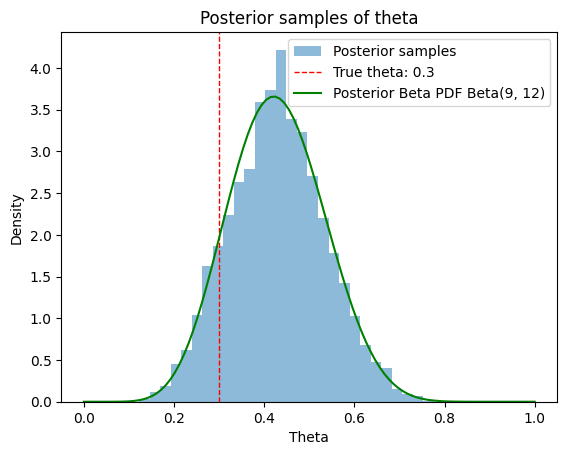

In [53]:
# Plot the histogram of the samples
plt.hist(theta_samples, bins=30, density=True, alpha=0.5, label='Posterior samples')
plt.axvline(theta, color='red', linestyle='dashed', linewidth=1, label=f'True theta: {theta}')
plt.plot(th, pdf_beta_post, label=f'Posterior Beta PDF Beta({alpha_post}, {beta_post})', color='green')
plt.title('Posterior samples of theta')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.legend()
plt.show()